# Initial Design

Previously, I tried doing an initial design using the full descriptor set, but found it didn't spread throughout the space well. Therefore, I am using the principal component space for the initial design. 

Also, I will need to evaporate the solvents, so it is best to not choose solvents with a really high boiling point (>140°C).  Conversely, if the boiling point of the solvent is too low, it will be really difficult to run the reaction since it won't be possible to achieve the needed reaction temeprature (120°C) without putting all the solvent in the gas phase (even with a pressurized reaction vessel + refluxing). So, I'm choosing to limit the optimization to solvents with boiling points between 80°C and 140°C.

Finally, I am limiting to solvents available in the lab since I am on a time constraint.

## 1. Load Dependencies

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, DescriptorsVariable
from summit.initial_design import LatinDesigner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [21]:
#This part is to load solvents available from cheminventory
# You can still reproduce the notebook without cheminventory because the available solvents
# will be loaded from a file

%load_ext dotenv
%dotenv
from cheminventory import ChemInventory
import pickle
from tqdm import tqdm_notebook
ci = ChemInventory() #username and password loaded from environmental variables (.env file)

## 2. Set up domain

In [168]:
#Calculate principal components
solvent_select = solvent_ds_full[(solvent_ds_full['boiling_point']>80) & 
                                   (solvent_ds_full['boiling_point']<140)]
num_components = 3

pca = PCA(n_components=num_components)
# pc.fit(solvent_ds_full.standardize())
pcs_practical = pca.fit_transform(solvent_select.standardize())
print(f"{round(pca.explained_variance_ratio_.sum()*100)}% of variance is explained by {num_components} principal components")

63.0% of variance is explained by 3 principal components


In [169]:
#Create a new dataset with just the principal components and descriptors as metadata
metadata_df = solvent_select.copy()
metadata_df.columns.set_codes(metadata_df.shape[1]*[1], level='TYPE', inplace=True)
pc_df = pd.DataFrame(pcs_practical, columns = [f'PC_{i}' for i in range(num_components)], 
                     index=metadata_df.index)
pc_ds = DataSet.from_df(pc_df)
solvent_ds_practical = pd.concat([metadata_df, pc_ds], axis=1)

In [171]:
# Get a list solvents available in the lab
def is_available(cas_number, ci):
    res = ci.search(cas_number)
    if res:
        return True
    else:
        return False
    
try:
    with open('solvents_available.pickle', 'rb') as f:
        solvents_available = pickle.load(f)
    print('Available solvents loaded from local file.')
except FileNotFoundError:
    solvents_available = [(cas, is_available(cas, ci))
                          for cas in tqdm_notebook(solvent_ds_practical.index)]
    with open('solvents_available.pickle', 'wb') as f:
        pickle.dump(solvents_available, f)

In [184]:
#Add available column to the dataset
available_ds = DataSet({('available', 'METADATA'): [available for _, available in solvents_available]},
                       index = [cas for cas, _ in solvents_available])
available_ds.columns.names = ['NAME', 'TYPE']
solvent_ds_lab = solvent_ds_practical.join(available_ds)
solvent_ds_lab = solvent_ds_lab[solvent_ds_lab['available']==True]

In [185]:
print(f"Number of solvents in datset: {solvent_ds_full.shape[0]}")
print(f"Number of solvents with boiling point b/w 80 and 140°C: {solvent_ds_practical.shape[0]}")
print(f"Number of those solvents in lab : {solvent_ds_lab.shape[0]}")

Number of solvents in datset: 459
Number of solvents with boiling point b/w 80 and 140°C: 135
Number of those solvents in lab : 43


In [203]:
domain_lab = Domain()
domain_lab += DescriptorsVariable('solvent',
                                  'solvents in the lab',
                                   solvent_ds_lab)
domain_lab

Name,Type,Description,Values
solvent,"descriptors, input",solvents in the lab,43 examples of 3 descriptors


## 3. Create the Initial Desgin

In [201]:
rs = np.random.RandomState(30) #seed the random number generator for a deterministic result
lhs = LatinDesigner(domain_lab, rs)
design_lab = lhs.generate_experiments(8, unique=True, criterion='maximin')
lab_indices = design_lab.get_indices()
final_selection = solvent_ds_lab.iloc[lab_indices[:, 0], :][solvent_ds_lab.metadata_columns]
final_selection.to_csv('outputs/initial_design.csv')
final_selection[['stenutz_name', 'boiling_point']]

,stenutz_name,boiling_point
cas_number,,
540-36-3,"1,4-difluorobenzene",89
96-22-0,3-pentanone,101
540-36-3,"1,4-difluorobenzene",89
64-19-7,acetic acid,118
142-82-5,heptane,98
142-68-7,oxane,88
110-86-1,pyridine,115
107-12-0,propanenitrile,97


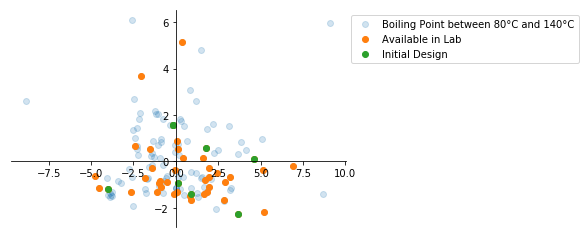

In [202]:
fig, ax = plt.subplots()
ax.scatter(pcs_practical[:, 0], pcs_practical[:, 1], 
           label='Boiling Point between 80°C and 140°C',
           alpha=0.2)
solvent_lab = solvent_ds_lab.data_to_numpy()
ax.scatter(solvent_lab[:, 0], solvent_lab[:,1], label="Available in Lab")
experiments_pcs_values = design_lab.get_values()
ax.scatter(experiments_pcs_values[:,0], experiments_pcs_values[:, 1], label='Initial Design')
ax.legend(bbox_to_anchor=(1, 1.0))
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.savefig('outputs/final_selection.png')
plt.savefig('outputs/final_selection.svg')